# Python implementation of the Max Unmix method for coercivity spectra analysis

This notebook illustrates the `rockmagpy` implementation of the MAX UnMix algorithm developed for unmixing magnetic coercivity spectra. MAX UnMix was originally written in R, is currently available within a Shiny app (https://shinyapps.carleton.edu/max-unmix/), and is documented in the paper:
> Maxbauer, D. P., Feinberg, J. M., & Fox, D. L. (2016). MAX UnMix: A web application for unmixing magnetic coercivity distributions. Computers & Geosciences, 95, 140–145. https://doi.org/10.1016/j.cageo.2016.07.009

Here, we start by using the example data file used in MaxUnmix and then continue to illustrate how the Python implementation enables batch analysis.

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [34]:
import pmagpy.rockmag as rmag
import pmagpy.ipmag as ipmag

import pmagpy.contribution_builder as cb
import pandas as pd
import matplotlib.pyplot as plt 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## MaxUnmix example
 
 Here we import the data that were published with MaxUnmix as an example file.

In [2]:
MaxUnmix_data = pd.read_csv('../example_data/backfield_unmixing/MaxUnmix_example.csv')
MaxUnmix_data['B'] = -MaxUnmix_data['B']/1000
MaxUnmix_data

,B,M
0,-0.00146,6.950000e-06
1,-0.00224,6.930000e-06
2,-0.00305,6.900000e-06
3,-0.00389,6.860000e-06
4,-0.00477,6.830000e-06
...,...,...
93,-0.84446,3.320000e-07
94,-0.88053,2.450000e-07
95,-0.91852,1.590000e-07
96,-0.95798,7.670000e-08


### backfield processing

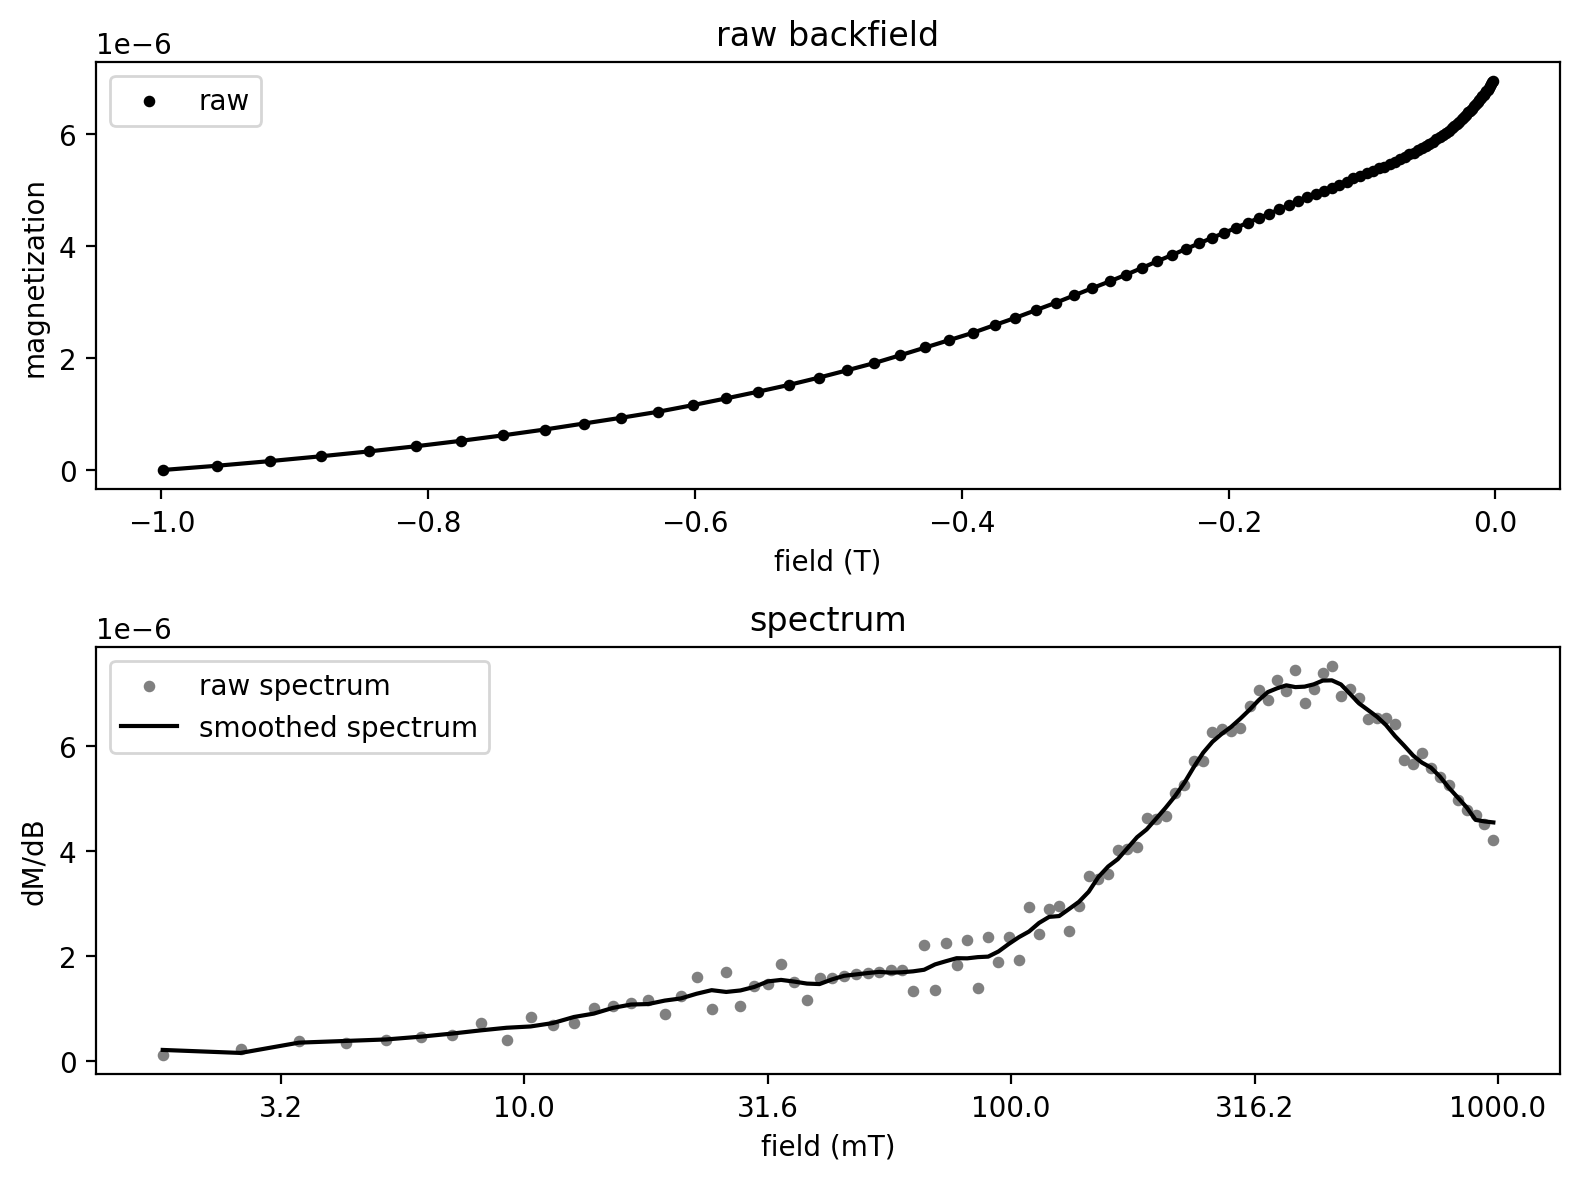

In [3]:
MaxUnmix_experiment, Bcr = rmag.backfield_data_processing(MaxUnmix_data, field='B', magnetization='M', smooth_frac=0.075)

fig, axs = rmag.plot_backfield_data(MaxUnmix_experiment, 
                                    field='B', magnetization='M', figsize=(8, 6), 
                                    plot_processed=False, plot_spectrum=True, return_figure=True)

### interactive fitting

An important aspect of the MaxUnmix process is for the user to make an initial guess for the parameters associated with the coercivity spectra that can then be optimized to fit. In the code cells below, the user can choose parameters that are then optimized by the code to become fits. An advantage to the approach implemented in rockmagpy, is rapid optimization. The user can specify the number of components to fit.

#### 1 component

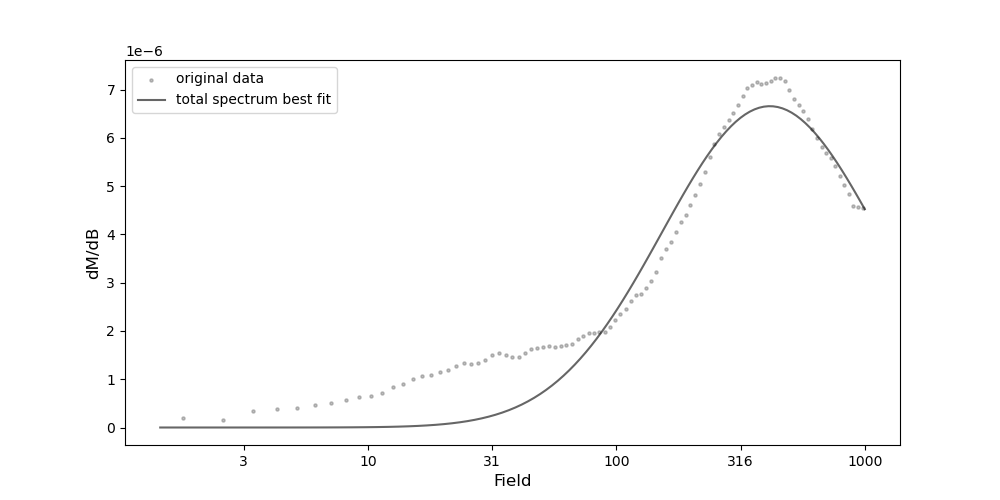

In [4]:
%matplotlib widget
one_fit = rmag.interactive_backfield_fit(MaxUnmix_experiment['smoothed_log_dc_field'], 
                               MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                               n_components=1, figsize=(10, 5))

In [5]:
one_fit

,amplitude,center,sigma,gamma
0,1.0,407.402769,2.7202,0.021476


#### 2 components

This example is not well-fit by one component — let's try two components.

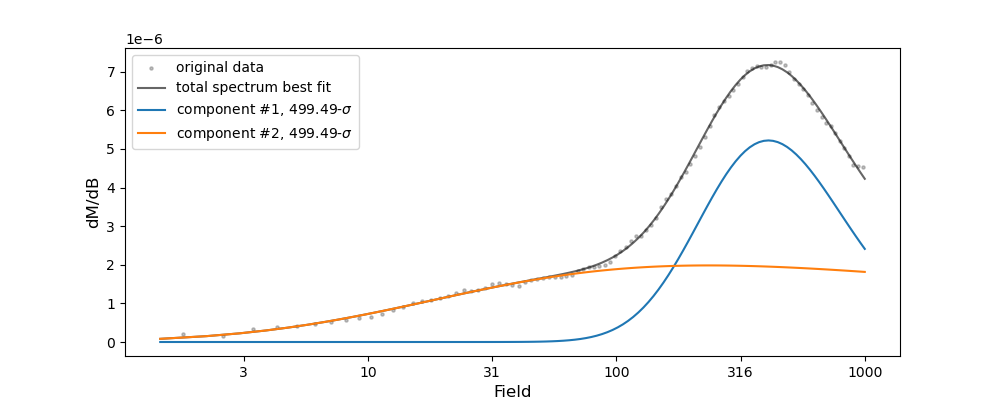

In [6]:
%matplotlib widget
two_fits = rmag.interactive_backfield_fit(MaxUnmix_experiment['smoothed_log_dc_field'], 
                               MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                               n_components=2, figsize=(10, 4))

In [7]:
two_fits

,amplitude,center,sigma,gamma
0,0.531629,249.219410,2.496574,1.431270
1,1.000000,20.051005,344.202713,3.909178


### MaxUnmix error estimate

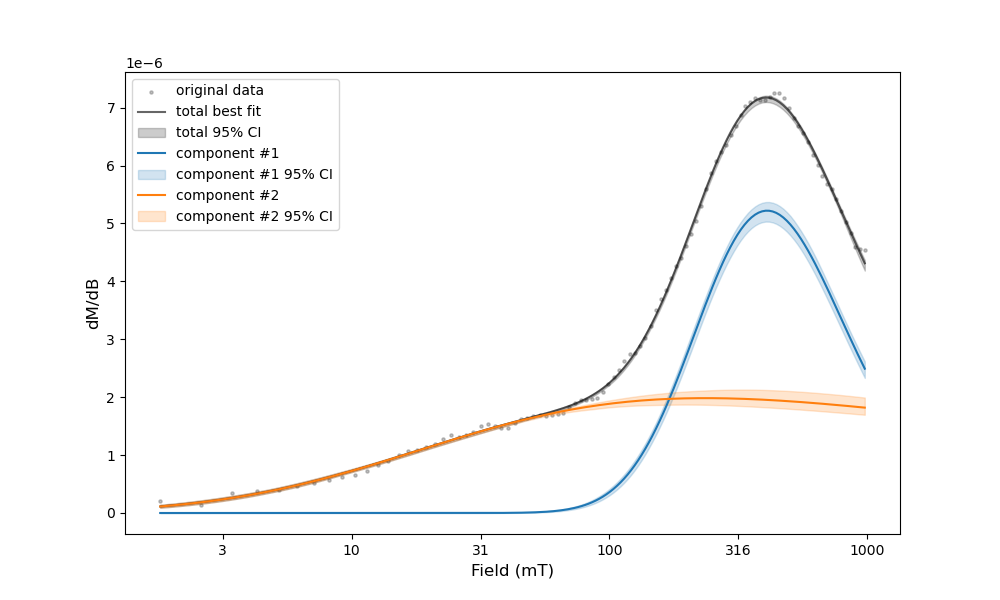

In [9]:
MaxUnmix_ax, MaxUnmix_params = rmag.backfield_MaxUnmix(MaxUnmix_experiment['smoothed_log_dc_field'], 
                                                            MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100)

In [10]:
MaxUnmix_params

{'g1_amplitude': 0.5307223354730236,
 'g1_center': 250.09362274333927,
 'g1_sigma': 2.485060288080717,
 'g1_gamma': 1.4160112853048434,
 'g1_amplitude_std': 0.010554474028322075,
 'g1_center_std': 1.0177949644228275,
 'g1_sigma_std': 1.0241354918377197,
 'g1_gamma_std': 0.09092430523620693,
 'g2_amplitude': 0.9991048538798091,
 'g2_center': 20.22345853541957,
 'g2_sigma': 338.68121564536756,
 'g2_gamma': 3.9016278500367463,
 'g2_amplitude_std': 0.004145645630097796,
 'g2_center_std': 1.1247882822594009,
 'g2_sigma_std': 1.3109995485275134,
 'g2_gamma_std': 0.40431158534307887}

In [14]:
dir_path = '../example_data/SwansonHysell2019'

MagIC_id = '20387'
share_key = '2deccada-115d-495c-964f-52f13f9786b2'

result, magic_file = ipmag.download_magic_from_id(MagIC_id, share_key=share_key, directory=dir_path)
ipmag.unpack_magic(magic_file, dir_path, print_progress=False)


Download successful. File saved to: ../example_data/SwansonHysell2019/magic_contribution_20387.txt
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/contribution.txt
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/locations.txt
8  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/sites.txt
74  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/samples.txt
486  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/specimens.txt
20944  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/SwansonHysell2019/measurements.txt


True

In [15]:
# get the contribution object
contribution = cb.Contribution(dir_path)
# get the measurements table
measurements = contribution.tables['measurements'].df
measurements = measurements.dropna(axis=1, how='all')
specimens = contribution.tables['specimens'].df

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


In [42]:
measurements_backfield = measurements[(measurements['method_codes'] == 'LP-BCR-BF')]
backfield_experiments = measurements_backfield['experiment'].unique()

In [57]:
backfield_experiment_1 = measurements_backfield[measurements_backfield['experiment'] == backfield_experiments[0]]
backfield_experiment_1.head()

,citations,dir_csd,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_x_sigma,magn_y_sigma,magn_z_sigma,meas_field_ac,meas_field_dc,meas_freq,meas_n_orient,meas_temp,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,timestamp,treat_ac_field,treat_dc_field,treat_dc_field_phi,treat_dc_field_theta,treat_step_num,treat_temp
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRIC-20cIRM-VSM2-LP-BCR-BF-1981061,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981061,LP-BCR-BF,g,7426,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000003,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981062,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981062,LP-BCR-BF,g,7427,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000251,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981063,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981063,LP-BCR-BF,g,7428,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000516,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981064,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981064,LP-BCR-BF,g,7429,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000799,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981065,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981065,LP-BCR-BF,g,743,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.001101,NaN,NaN,NaN,NaN


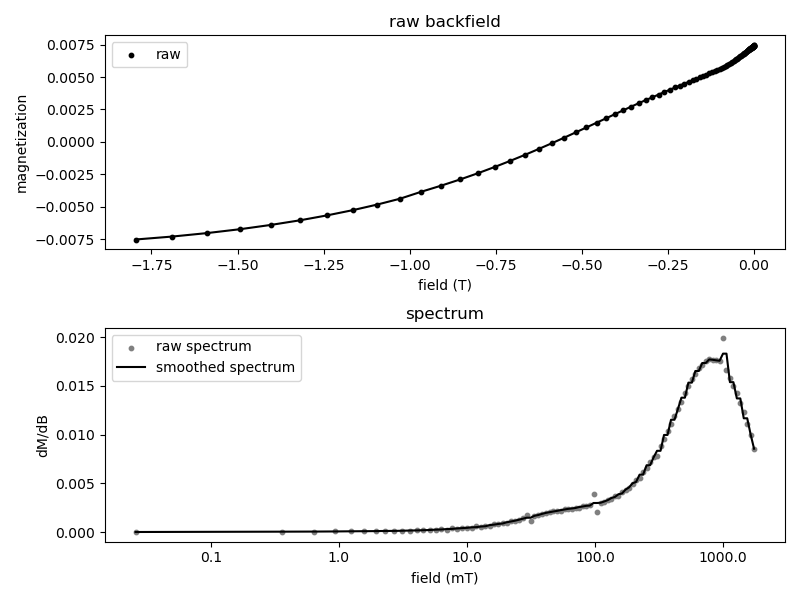

In [58]:
experiment_1, Bcr = rmag.backfield_data_processing(backfield_experiment_1, 
                                                          field='treat_dc_field', magnetization='magn_mass', 
                                                          smooth_frac=0.05)

fig, axs = rmag.plot_backfield_data(experiment_1, 
                                    field='treat_dc_field', magnetization='magn_mass', figsize=(8, 6), 
                                    plot_processed=False, plot_spectrum=True, return_figure=True)

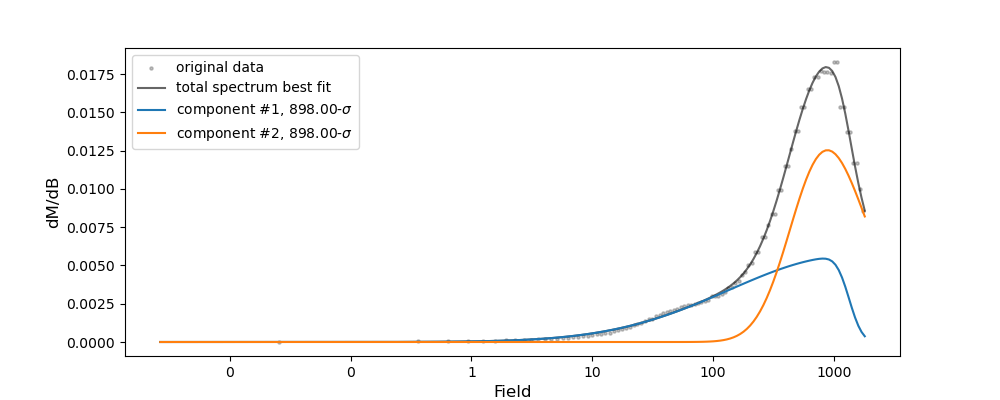

In [59]:
%matplotlib widget
two_fits = rmag.interactive_backfield_fit(experiment_1['smoothed_log_dc_field'], 
                               experiment_1['smoothed_magn_mass_shift'], 
                               n_components=2, figsize=(10, 4))

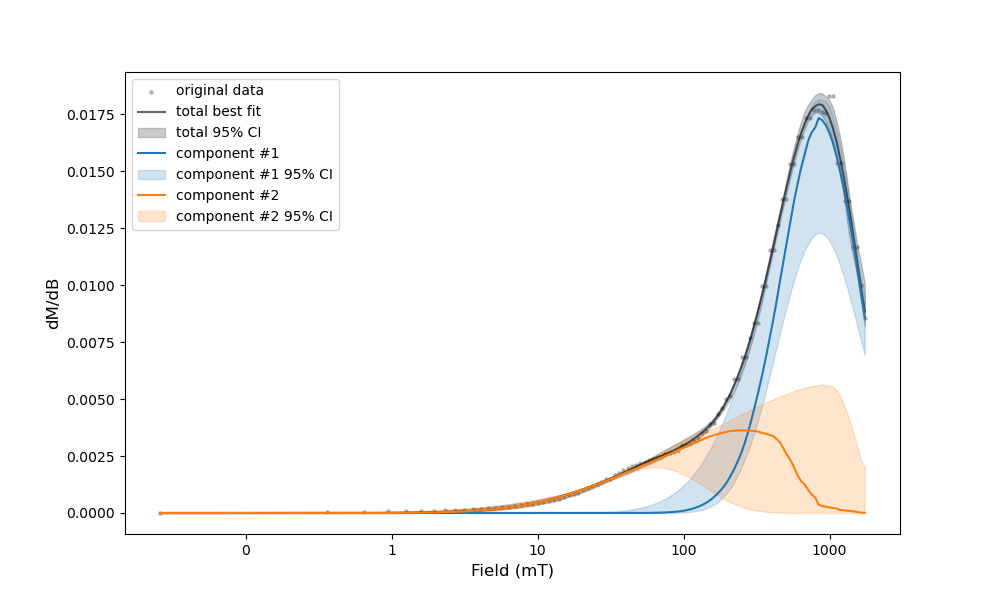

In [ ]:
experiment_1_ax, experiment_1_params = rmag.backfield_MaxUnmix(experiment_1['smoothed_log_dc_field'], 
                                                            experiment_1['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100)

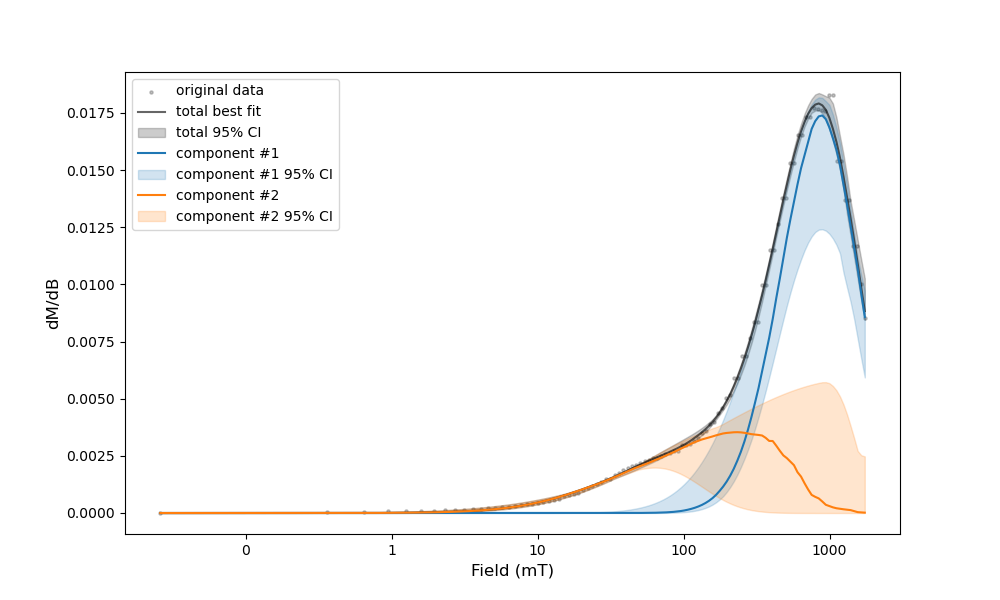

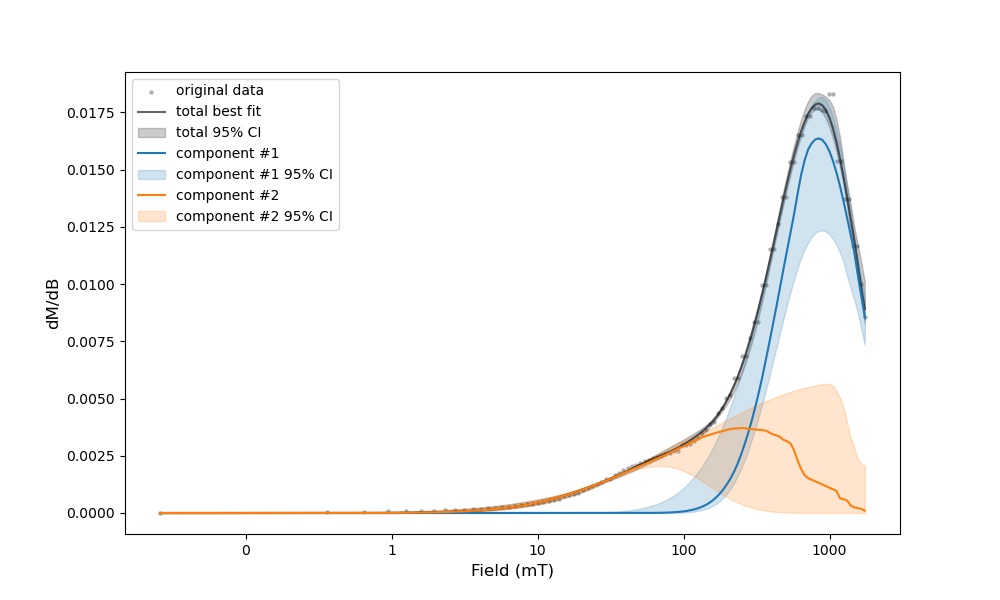

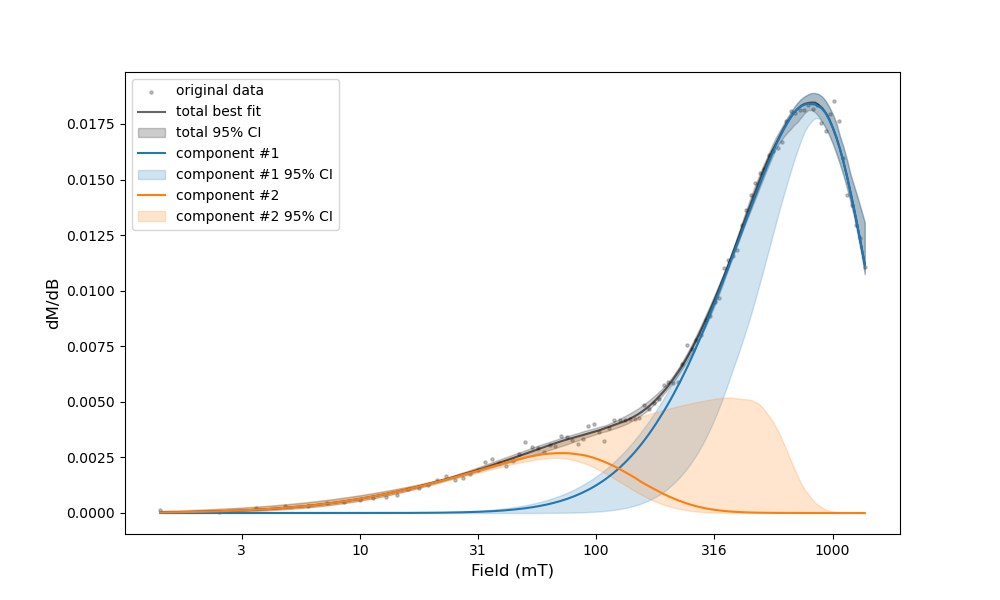

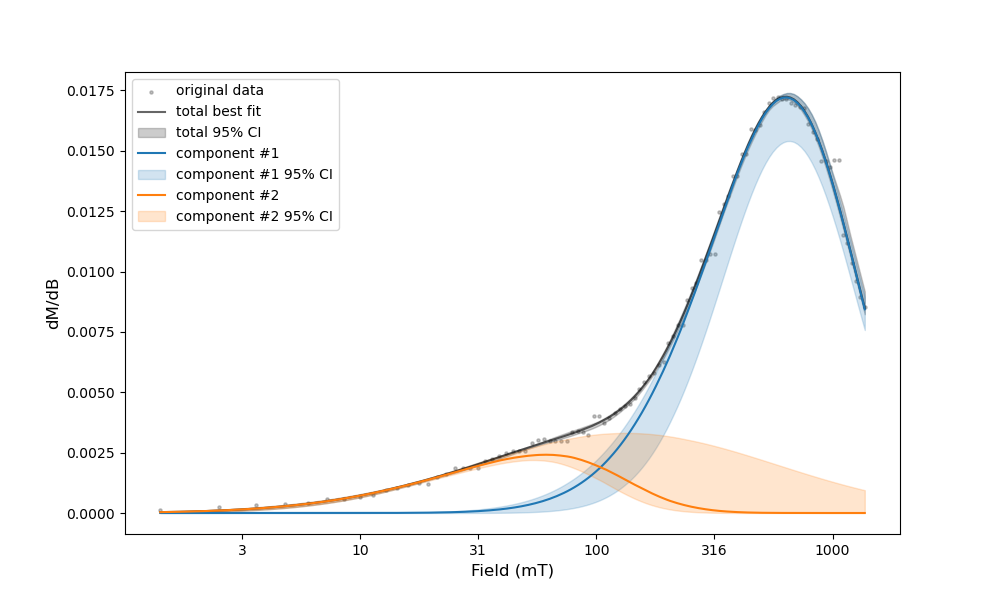

In [67]:
params_by_experiment = {}

for ex in backfield_experiments[0:4]:
    backfield_experiment = measurements_backfield[measurements_backfield['experiment'] == ex]
    experiment, Bcr = rmag.backfield_data_processing(backfield_experiment, 
                                                          field='treat_dc_field', magnetization='magn_mass', 
                                                          smooth_frac=0.05)
    experiment_ax, experiment_params = rmag.backfield_MaxUnmix(experiment['smoothed_log_dc_field'], 
                                                            experiment['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100)
    fig = experiment_ax.get_figure()
    plt.show(fig)